In [22]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local[*]").appName('Final_Project')\
    .config('spark.executor.memory','16g')\
    .config('spark.driver.memory','16g')\
    .config('spark.driver.maxResultsSize','0')\
    .getOrCreate()
sc = spark.sparkContext

In [24]:
df = spark.read.option('header','true').csv('2018.csv',inferSchema=True)


In [25]:
df.dtypes

[('FL_DATE', 'string'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'int'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'int'),
 ('DEP_TIME', 'double'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('WHEELS_OFF', 'double'),
 ('WHEELS_ON', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'int'),
 ('ARR_TIME', 'double'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'double'),
 ('CANCELLATION_CODE', 'string'),
 ('DIVERTED', 'double'),
 ('CRS_ELAPSED_TIME', 'double'),
 ('ACTUAL_ELAPSED_TIME', 'double'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('CARRIER_DELAY', 'double'),
 ('WEATHER_DELAY', 'double'),
 ('NAS_DELAY', 'double'),
 ('SECURITY_DELAY', 'double'),
 ('LATE_AIRCRAFT_DELAY', 'double'),
 ('Unnamed: 27', 'string')]

In [26]:
from pyspark.sql.functions import *
#df.select([count(when(col(c).contains('None') | \
#                            col(c).contains('NULL') | \
#                            (col(c) == '' ) | \
#                            col(c).isNull() | \
#                            isnan(c), c 
#                           )).alias(c)
#                    for c in df.columns]).show()

In [27]:
#drop useless
df = df.drop("OP_CARRIER_FL_NUM","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CANCELLATION_CODE","DIVERTED","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY","Unnamed: 27","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME")
df = df.na.drop()

In [28]:
#add index
from pyspark.sql.functions import monotonically_increasing_id
df = df.select("*").withColumn("id", monotonically_increasing_id())
df.show(5)

+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DISTANCE| id|
+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+
|2018-01-01|        UA|   EWR| DEN|        1517|  1512.0|     -5.0|        1745|  1722.0|    -23.0|      0.0|  1605.0|  0|
|2018-01-01|        UA|   LAS| SFO|        1115|  1107.0|     -8.0|        1254|  1230.0|    -24.0|      0.0|   414.0|  1|
|2018-01-01|        UA|   SNA| DEN|        1335|  1330.0|     -5.0|        1649|  1636.0|    -13.0|      0.0|   846.0|  2|
|2018-01-01|        UA|   RSW| ORD|        1546|  1552.0|      6.0|        1756|  1754.0|     -2.0|      0.0|  1120.0|  3|
|2018-01-01|        UA|   ORD| ALB|         630|   650.0|     20.0|         922|   936.0|     14.0|      0.0|   723.0|  4|
+----------+----

In [29]:
# association between origin and delay
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df.registerTempTable('table')

In [30]:
df1 = sqlContext.sql('select ORIGIN, count(DEP_DELAY) as Delay_num from table where DEP_DELAY > 0.0 group by ORIGIN order by ORIGIN')
df1.show()
df1.registerTempTable('table1')

+------+---------+
|ORIGIN|Delay_num|
+------+---------+
|   ABE|     1240|
|   ABI|      599|
|   ABQ|     8667|
|   ABR|      154|
|   ABY|      283|
|   ACK|      341|
|   ACT|      384|
|   ACV|      427|
|   ACY|      633|
|   ADK|       43|
|   ADQ|      152|
|   AEX|      723|
|   AGS|     1453|
|   AKN|       27|
|   ALB|     3715|
|   ALO|      172|
|   AMA|     1410|
|   ANC|     3385|
|   APN|      159|
|   ART|       19|
+------+---------+
only showing top 20 rows



In [31]:
df2 = sqlContext.sql('select ORIGIN, count(id) as total from table group by ORIGIN order by total desc')
df2.registerTempTable('table2')

In [57]:
df2.show()

+------+------+
|ORIGIN| total|
+------+------+
|   ATL|385662|
|   ORD|324838|
|   DFW|273169|
|   DEN|233741|
|   CLT|226712|
|   LAX|218992|
|   SFO|172958|
|   PHX|172275|
|   IAH|171485|
|   LGA|163002|
|   LAS|159656|
|   MSP|156840|
|   DTW|154914|
|   BOS|143771|
|   SEA|139015|
|   EWR|138861|
|   MCO|136517|
|   DCA|128305|
|   JFK|125194|
|   PHL|113476|
+------+------+
only showing top 20 rows



In [32]:
df1 = sqlContext.sql('select ORIGIN, Delay_num, total,total-Delay_num as No_Delay, Delay_num/total as Delay_rate from table2 left join table1 using(ORIGIN) order by total desc')
dfsort = sqlContext.sql('select ORIGIN, Delay_num, total,total-Delay_num as No_Delay, Delay_num/total as Delay_rate from table2 left join table1 using(ORIGIN) order by Delay_rate desc')
df_STL = sqlContext.sql('select ORIGIN, Delay_num, total,total-Delay_num as No_Delay, Delay_num/total as Delay_rate from table2 left join table1 using(ORIGIN) where ORIGIN = "STL" ')
df_STL.show()
# calculate rate

+------+---------+-----+--------+------------------+
|ORIGIN|Delay_num|total|No_Delay|        Delay_rate|
+------+---------+-----+--------+------------------+
|   STL|    29746|65012|   35266|0.4575462991447733|
+------+---------+-----+--------+------------------+



In [59]:
df1.show(3)

+------+---------+------+--------+------------------+
|ORIGIN|Delay_num| total|No_Delay|        Delay_rate|
+------+---------+------+--------+------------------+
|   ATL|   140577|385662|  245085|0.3645083000140019|
|   ORD|   112143|324838|  212695|0.3452274672298192|
|   DFW|   100447|273169|  172722|0.3677100988765197|
+------+---------+------+--------+------------------+
only showing top 3 rows



In [33]:
# Add DistanceType
df = df.withColumn("DistanceType",  when((df.DISTANCE > 1400), lit(1)) \
     .otherwise(lit(0)))
df.show(5)

+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DISTANCE| id|DistanceType|
+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+
|2018-01-01|        UA|   EWR| DEN|        1517|  1512.0|     -5.0|        1745|  1722.0|    -23.0|      0.0|  1605.0|  0|           1|
|2018-01-01|        UA|   LAS| SFO|        1115|  1107.0|     -8.0|        1254|  1230.0|    -24.0|      0.0|   414.0|  1|           0|
|2018-01-01|        UA|   SNA| DEN|        1335|  1330.0|     -5.0|        1649|  1636.0|    -13.0|      0.0|   846.0|  2|           0|
|2018-01-01|        UA|   RSW| ORD|        1546|  1552.0|      6.0|        1756|  1754.0|     -2.0|      0.0|  1120.0|  3|           0|
|2018-01-01|        UA|   ORD| ALB|         630|

In [34]:
# association between distance and delay
df.registerTempTable('table')
df3 = sqlContext.sql('select DistanceType, count(DEP_DELAY) as Delay_num from table where DEP_DELAY > 0.0 group by DistanceType')
df4 = sqlContext.sql('select DistanceType, count(id) as total from table group by DistanceType')
df3.registerTempTable('table3')
df4.registerTempTable('table4')

df3 = sqlContext.sql('select DistanceType, Delay_num, total,total-Delay_num as No_delay, Delay_num/total as Delay_rate from table3 left join table4 using(DistanceType)')
df3.show()

+------------+---------+-------+--------+-------------------+
|DistanceType|Delay_num|  total|No_delay|         Delay_rate|
+------------+---------+-------+--------+-------------------+
|           1|   391740|1024665|  632925| 0.3823103160545154|
|           0|  2045310|6047153| 4001843|0.33822693092104666|
+------------+---------+-------+--------+-------------------+



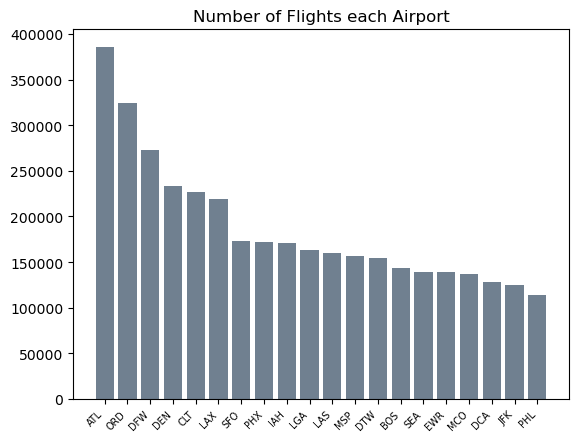

In [60]:
# Plot Airport and total
index = list(df2.select('ORIGIN').toPandas()['ORIGIN'])
values = list(df2.select('total').toPandas()['total'])

import matplotlib.pyplot as plt
plt.title('Number of Flights each Airport')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)
plt.bar(index[0:20],values[0:20],color='slategrey',ecolor='black')
plt.savefig(r'\airport.png',transparent = True)

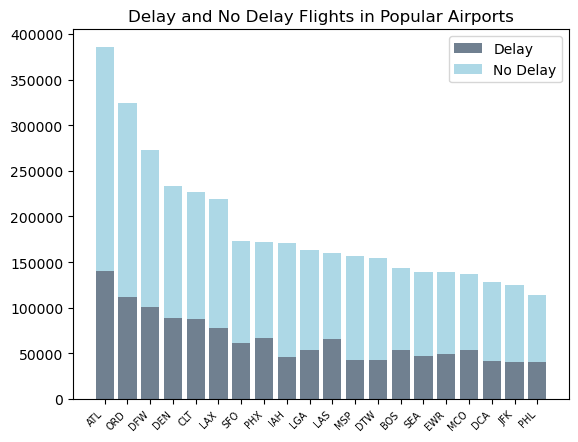

In [61]:
# plot airport no delay & delay
import numpy as np
origin = list(df1.select('ORIGIN').toPandas()['ORIGIN'])
delay = list(df1.select('Delay_num').toPandas()['Delay_num'])
nodelay = list(df1.select('No_Delay').toPandas()['No_Delay'])

series1 = np.array(delay[0:20])
series2 = np.array(nodelay[0:20])

index = origin[0:20]

plt.title('Delay and No Delay Flights in Popular Airports')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

plt.bar(index,series1,color='slategrey')
plt.bar(index,series2,color='lightblue',bottom=series1)
plt.legend(['Delay', 'No Delay'])
plt.savefig(r'\airportde.png',transparent = True)

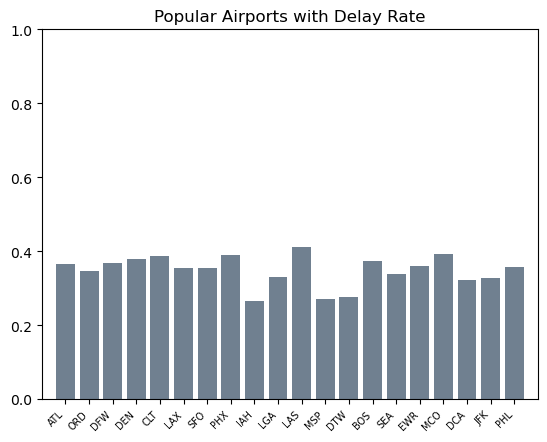

In [62]:
# Plot popular airport and rate

index = list(df1.select('ORIGIN').toPandas()['ORIGIN'])
values = list(df1.select('Delay_rate').toPandas()['Delay_rate'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

plt.axis([-1,20,0,1])
plt.title('Popular Airports with Delay Rate')
plt.bar(index[0:20],values[0:20],color='slategrey',ecolor='black')
plt.savefig(r'\airportnosort.png',transparent = True)
plt.savefig(r'\airportr.png',transparent = True)

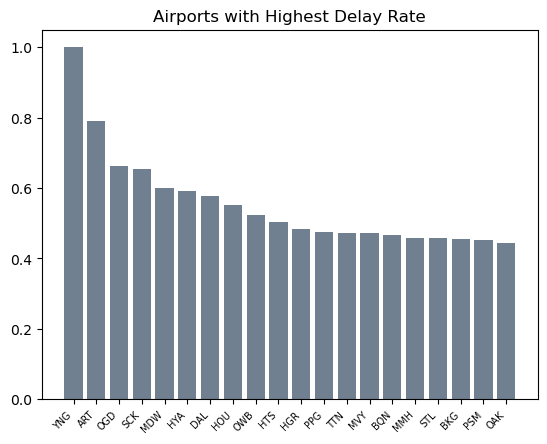

In [63]:
# Plot airport with highest rate

index = list(dfsort.select('ORIGIN').toPandas()['ORIGIN'])
values = list(dfsort.select('Delay_rate').toPandas()['Delay_rate'])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

plt.title('Airports with Highest Delay Rate')
plt.bar(index[0:20],values[0:20],color='slategrey',ecolor='black')
plt.savefig(r'\airporthr.png',transparent = True)

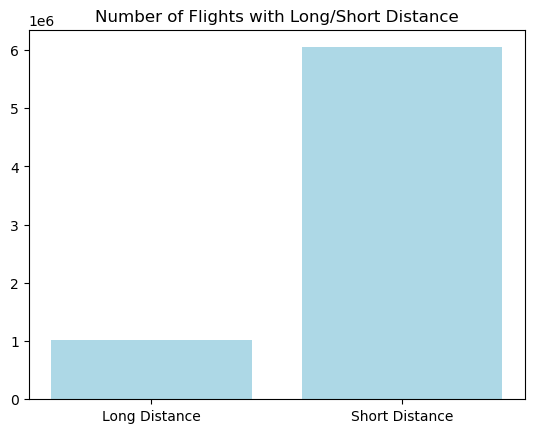

In [64]:
# Plot distance and total
index = ['Long Distance','Short Distance']
values = list(df4.select('total').toPandas()['total'])

import matplotlib.pyplot as plt

plt.title('Number of Flights with Long/Short Distance')

plt.bar(index,values,color='lightblue',ecolor='black')
plt.savefig(r'\distance.png',transparent = True)

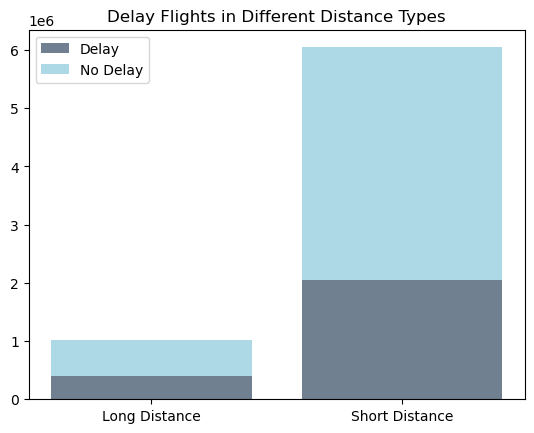

In [65]:
#plot distance & no delay & delay
distance = ['Long Distance','Short Distance']
delay = list(df3.select('Delay_num').toPandas()['Delay_num'])
nodelay = list(df3.select('No_delay').toPandas()['No_delay'])

series1 = np.array(delay)
series2 = np.array(nodelay)

index = distance

plt.title('Delay Flights in Different Distance Types')

plt.bar(index,series1,color='slategrey')
plt.bar(index,series2,color='lightblue',bottom=series1)
plt.legend(['Delay', 'No Delay'])
plt.savefig(r'\distancede.png',transparent = True)

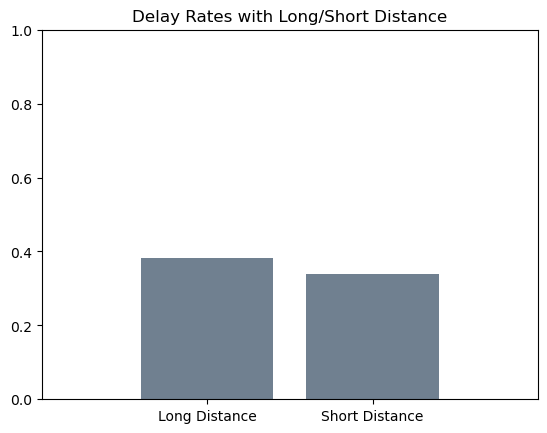

In [66]:
# Plot distance and rate
index = ['Long Distance','Short Distance']
values = list(df3.select('Delay_rate').toPandas()['Delay_rate'])

import matplotlib.pyplot as plt

plt.axis([-1,2,0,1])
plt.title('Delay Rates with Long/Short Distance')

plt.bar(index,values,color='slategrey',ecolor='black')
plt.savefig(r'\distancer.png',transparent = True)
plt.savefig(r'\distancer.png',transparent = True)

In [42]:
dfAirline = sqlContext.sql('select OP_CARRIER, count(id) as total from table group by OP_CARRIER')
dfAirlinede = sqlContext.sql('select OP_CARRIER, count(DEP_DELAY) as Delay_num from table where DEP_DELAY > 0.0 group by OP_CARRIER')

dfAirline.registerTempTable('tableA')
dfAirlinede.registerTempTable('tableAD')

In [43]:
dfA = sqlContext.sql('select OP_CARRIER, Delay_num, total,total-Delay_num as No_delay, Delay_num/total as Delay_rate from tableA left join tableAD using(OP_CARRIER) order by total desc')
dfAsort = sqlContext.sql('select OP_CARRIER, Delay_num, total,total-Delay_num as No_delay, Delay_num/total as Delay_rate from tableA left join tableAD using(OP_CARRIER) order by Delay_rate desc')
dfAsort.show()

+----------+---------+-------+--------+-------------------+
|OP_CARRIER|Delay_num|  total|No_delay|         Delay_rate|
+----------+---------+-------+--------+-------------------+
|        WN|   660551|1331609|  671058|0.49605477283496885|
|        F9|    53187| 117523|   64336| 0.4525667316184917|
|        B6|   124396| 297758|  173362| 0.4177755089703719|
|        OH|    99616| 265784|  166168|0.37480058995274357|
|        AA|   316038| 899527|  583489|0.35133798096110513|
|        G4|    32787|  95192|   62405| 0.3444302042188419|
|        VX|     5346|  17153|   11807| 0.3116655978546027|
|        DL|   285156| 943837|  658681| 0.3021242015305609|
|        UA|   184285| 614915|  430630|0.29969182732572797|
|        NK|    50951| 174129|  123178| 0.2926049078556702|
|        MQ|    82746| 284497|  201751|0.29085016713708756|
|        YV|    59935| 209094|  149159| 0.2866414148660411|
|        9E|    63776| 231815|  168039| 0.2751159329637858|
|        EV|    53563| 196583|  143020|0

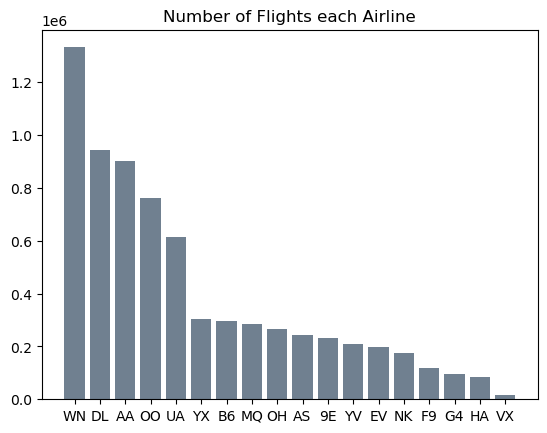

In [67]:
# Plot airline and total

index = list(dfA.select('OP_CARRIER').toPandas()['OP_CARRIER'])
values = list(dfA.select('total').toPandas()['total'])

plt.title('Number of Flights each Airline')
plt.bar(index[0:20],values[0:20],color='slategrey',ecolor='black')
plt.savefig(r'\airline.png',transparent = True)

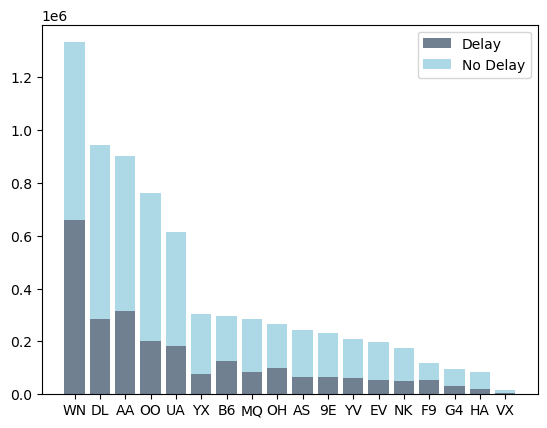

In [68]:
# plot popular airline & no delay & delay
carry = list(dfA.select('OP_CARRIER').toPandas()['OP_CARRIER'])
delay = list(dfA.select('Delay_num').toPandas()['Delay_num'])
nodelay = list(dfA.select('No_Delay').toPandas()['No_Delay'])

series1 = np.array(delay[0:20])
series2 = np.array(nodelay[0:20])

index = carry[0:20]

plt.bar(index,series1,color='slategrey')
plt.bar(index,series2,color='lightblue',bottom=series1)
plt.legend(['Delay', 'No Delay'])
plt.savefig(r'\airlinede.png',transparent = True)

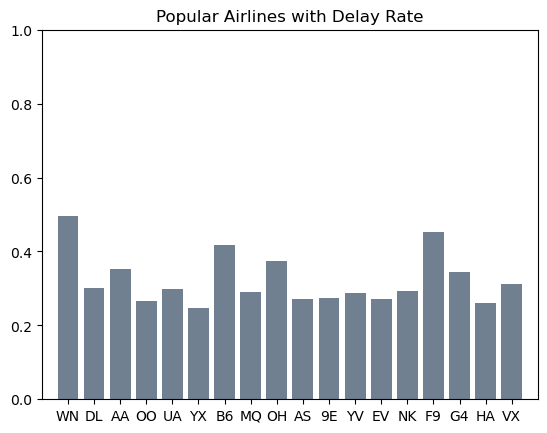

In [69]:
# popular airline and rate
carry = list(dfA.select('OP_CARRIER').toPandas()['OP_CARRIER'])
delay = list(dfA.select('Delay_rate').toPandas()['Delay_rate'])

plt.axis([-1,18,0,1])
plt.title('Popular Airlines with Delay Rate')
plt.bar(carry,delay,color='slategrey',ecolor='black')
plt.savefig(r'\airlinenosort.png',transparent = True)
plt.savefig(r'\airliner.png',transparent = True)

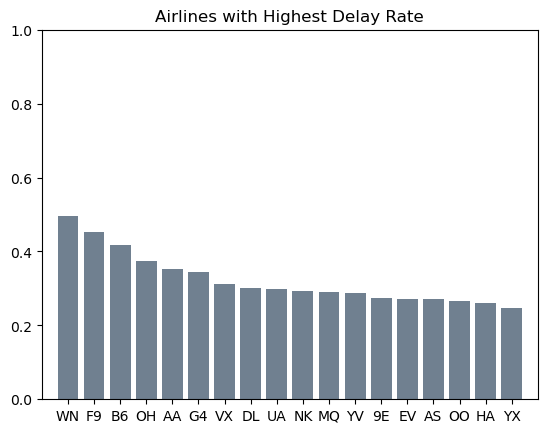

In [70]:
#airline with highest rate
carry = list(dfAsort.select('OP_CARRIER').toPandas()['OP_CARRIER'])
delayrate = list(dfAsort.select('Delay_rate').toPandas()['Delay_rate'])

plt.axis([-1,18,0,1])
plt.title('Airlines with Highest Delay Rate')
plt.bar(carry,delayrate,color='slategrey',ecolor='black')
plt.savefig(r'\airlinehr.png',transparent = True)


In [48]:
#how many airports do we have
airport = list(df1.select('ORIGIN').toPandas()['ORIGIN'])
len(airport)

358

In [49]:
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.sql.functions import lit
df = df.withColumn("DelayOrNot", when((df.DEP_DELAY > 0), lit(1)) \
     .otherwise(lit(0)))
df.show(5)

+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+----------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DISTANCE| id|DistanceType|DelayOrNot|
+----------+----------+------+----+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+----------+
|2018-01-01|        UA|   EWR| DEN|        1517|  1512.0|     -5.0|        1745|  1722.0|    -23.0|      0.0|  1605.0|  0|           1|         0|
|2018-01-01|        UA|   LAS| SFO|        1115|  1107.0|     -8.0|        1254|  1230.0|    -24.0|      0.0|   414.0|  1|           0|         0|
|2018-01-01|        UA|   SNA| DEN|        1335|  1330.0|     -5.0|        1649|  1636.0|    -13.0|      0.0|   846.0|  2|           0|         0|
|2018-01-01|        UA|   RSW| ORD|        1546|  1552.0|      6.0|        1756|  1754.0|     -2.0|      0.0|  1120.0|

In [50]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index")
            .fit(df) for column in ['OP_CARRIER','ORIGIN','DEST']]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)
df = df.drop('OP_CARRIER','ORIGIN','DEST')
df.show(5)

+----------+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+----------+----------------+------------+----------+
|   FL_DATE|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DISTANCE| id|DistanceType|DelayOrNot|OP_CARRIER_index|ORIGIN_index|DEST_index|
+----------+------------+--------+---------+------------+--------+---------+---------+--------+---+------------+----------+----------------+------------+----------+
|2018-01-01|        1517|  1512.0|     -5.0|        1745|  1722.0|    -23.0|      0.0|  1605.0|  0|           1|         0|             4.0|        15.0|       3.0|
|2018-01-01|        1115|  1107.0|     -8.0|        1254|  1230.0|    -24.0|      0.0|   414.0|  1|           0|         0|             4.0|        10.0|       6.0|
|2018-01-01|        1335|  1330.0|     -5.0|        1649|  1636.0|    -13.0|      0.0|   846.0|  2|           0|         0|             4.0|        46.0|       3.0|
|2018-01-0

In [51]:
df = df.withColumn("ORIGIN_index_int",df.ORIGIN_index.cast('int'))
df = df.drop('ORIGIN_index')

In [52]:
df_select = df.select('DelayOrNot','DISTANCE','CRS_DEP_TIME','OP_CARRIER_index','ORIGIN_index_int')
feature = VectorAssembler(inputCols=df_select.columns[1:],outputCol="features")
feature_vector= feature.transform(df_select)
feature_vector.show(5)

(trainingData, testData) = feature_vector.randomSplit([0.4, 0.6],seed = 42)

+----------+--------+------------+----------------+----------------+--------------------+
|DelayOrNot|DISTANCE|CRS_DEP_TIME|OP_CARRIER_index|ORIGIN_index_int|            features|
+----------+--------+------------+----------------+----------------+--------------------+
|         0|  1605.0|        1517|             4.0|              15|[1605.0,1517.0,4....|
|         0|   414.0|        1115|             4.0|              10|[414.0,1115.0,4.0...|
|         0|   846.0|        1335|             4.0|              46|[846.0,1335.0,4.0...|
|         1|  1120.0|        1546|             4.0|              49|[1120.0,1546.0,4....|
|         1|   723.0|         630|             4.0|               1|[723.0,630.0,4.0,...|
+----------+--------+------------+----------------+----------------+--------------------+
only showing top 5 rows



In [53]:
#building a decision tree classifier model
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="DelayOrNot", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
dt_prediction.select("prediction", "DelayOrNot", "features").show(10)

+----------+----------+--------------------+
|prediction|DelayOrNot|            features|
+----------+----------+--------------------+
|       0.0|         0|[31.0,1101.0,9.0,...|
|       0.0|         0|[31.0,1101.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1106.0,9.0,...|
+----------+----------+--------------------+
only showing top 10 rows



In [54]:
#print out accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="DelayOrNot", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 0.679867
Test Error of DecisionTreeClassifier = 0.320133 


In [55]:
#building logisticregression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr = LogisticRegression(labelCol="DelayOrNot", featuresCol="features")
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "DelayOrNot", "features").show(10)

22/12/08 13:47:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/08 13:47:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+----------+----------+--------------------+
|prediction|DelayOrNot|            features|
+----------+----------+--------------------+
|       0.0|         0|[31.0,1101.0,9.0,...|
|       0.0|         0|[31.0,1101.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1102.0,9.0,...|
|       0.0|         0|[31.0,1106.0,9.0,...|
+----------+----------+--------------------+
only showing top 10 rows



In [56]:
evaluator = MulticlassClassificationEvaluator(labelCol="DelayOrNot", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.653823
Test Error of LogisticRegression = 0.346177 


22/12/08 15:32:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 322052 ms exceeds timeout 120000 ms
22/12/08 15:32:15 WARN SparkContext: Killing executors is not supported by current scheduler.
